In [ ]:
from ollama import generate as ollama_generate
import json
from os import listdir
from os.path import join,basename,exists
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Video
from os import makedirs
from tabulate import tabulate

In [ ]:
data_dir = "AUG29"
key_frame_dir = join(data_dir, "key_frames")
video_dir = join(data_dir, "videos")
analysed_video_frames_path = join(data_dir, "analysed_video_frames.json")


In [ ]:
if not exists(data_dir):
    print(f"Creating directory {data_dir}")
    makedirs(data_dir)

if not exists(video_dir):
    print(f"Creating directory {video_dir}")
    makedirs(video_dir)

if not exists(key_frame_dir):
    print(f"Creating directory {key_frame_dir}")
    makedirs(key_frame_dir)

In [ ]:
# extract key frames from a video file and save them as images in a directory
def extract_key_frames(video_path, output_path, threshold=30.0, prefix=None, verbose=False):
    from os.path import exists, join
    from os import makedirs
    from numpy import mean, std, log
    import cv2 as cv

    if prefix is None:
        prefix = ""
    else:
        prefix = f"{prefix}_"

    # Create the output directory if it doesn't exist
    if not exists(output_path):
        makedirs(output_path)
        
    # Capture the video from the file
    cap = cv.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return

    # get frame rate and total number of frames
    fps = cap.get(cv.CAP_PROP_FPS)
    frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
    duration = frame_count/fps
    min_key_frame_separation = max(1, duration/20)

    # it is not necessary to check every single frame.
    # Some heuristics calculates an appropriate interval
    frame_check_interval = int(0.33 * log(10+0.5) * fps)

    if verbose:
        print(f"Frames:{frame_count} | FPS:{fps:.0f} | Dur:{duration:.1f}s | Check interval:{frame_check_interval} | Min key frame separation:{min_key_frame_separation:.1f}s")

    # Read the first frame
    ret, prev_frame = cap.read()
    if not ret:
        print("Cannot read video file")
        return

    # Convert frame to grayscale
    prev_gray = cv.cvtColor(prev_frame, cv.COLOR_BGR2GRAY)

    # Initialize frame count and other things
    frame_idx = 0
    key_frame_idx_list = []
    key_frames = []
    key_frame_sharpness_list = []
    all_frames_sharpness_list = []
    last_saved_frame_idx = 0

    # Loop through all frames
    while True:
        # Read next frame
        ret, frame = cap.read()
        if not ret:
            break

        # Check if it's time to check the frame
        if frame_idx % frame_check_interval == 0:

            # Convert current frame to grayscale
            gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

            # Calculate absolute difference between frames to detect changes
            diff = cv.absdiff(prev_gray, gray)
            mean_diff = mean(diff)

            # Apply Laplacian operator to calculate blurriness/sharpness of the frame
            # since we only want to keep reasonably sharp key frames and add to a list of all frames
            frame_sharpness_metric = cv.Laplacian(gray, cv.CV_64F).var()
            all_frames_sharpness_list.append(frame_sharpness_metric)

            

            # If diff between the frames is greater than threshold, assume this is a key frame.
            # But only if it's been a while since the last key frame or if this is at the beginning
            # of the video since some videos start with a black frame or something like that
            # Also save the first and last (-ish) frame
            if (mean_diff > threshold and ((frame_idx - last_saved_frame_idx > fps * min_key_frame_separation) or (frame_idx < fps*0.5))) or frame_idx == 0 or frame_idx == frame_count - 2:
            
                # Copy the index into a prev-variable
                last_saved_frame_idx = frame_idx

                # Add the key frame index to the list of key frame indices
                key_frame_idx_list.append(frame_idx)

                # Add the key frame to the list of key frames
                key_frames.append(frame)

                # Add the sharpness metric to the list of sharpness metrics
                key_frame_sharpness_list.append(frame_sharpness_metric)

                # Update previous gray frame
                prev_gray = gray

        # Update index counter
        frame_idx += 1

    # When all frames have been checked, release the video capture
    cap.release()

    # Calculate mean and standard deviation of sharpness metrics for all frames
    mean_sharpness = mean(all_frames_sharpness_list)
    std_sharpness = std(all_frames_sharpness_list)

    # Calculate the threshold for minimum sharpness based on some heuristics
    min_sharpness_threshold = max(mean_sharpness - 1.5 * std_sharpness, mean_sharpness*0.66)

    # counter for saved key frames
    saved_key_frame_count = 0

    # print things
    if verbose:
        print(f"Sharpness - Mean:{mean_sharpness:.2f} | Std:{std_sharpness:.2f} | Thresh:{min_sharpness_threshold:.2f}")

    # Loop through key frames
    for i, frame_sharpness in enumerate(key_frame_sharpness_list):
        # Save key frame if it's sharp enough
        if frame_sharpness > min_sharpness_threshold or len(key_frames) <= 5:
            key_time = key_frame_idx_list[i]/fps

            print("S",end="",flush=True)

            # Save frame as JPEG file
            filename = join(
                output_path, prefix+f"F{key_frame_idx_list[i]}_T{key_time:.0f}.jpg")
            cv.imwrite(filename, key_frames[i])
            saved_key_frame_count += 1
        else:
            print(".",end="",flush=True)


    print(f" | {saved_key_frame_count}/{len(key_frame_idx_list)} key frames saved w prefix {join(output_path, prefix)}")
    return key_frame_idx_list

In [ ]:
def generate_ollama_frame_analysis(a_frame, the_model='llava:latest'):
      
      #frame_prompt = 'generate a json formatted data structure with the following about this image: main_activity; location; human_count; guessed_genders; observed_ages_of_humans; emotions; ethnicities_observed. If it is not possible to determine the data, respond with unknown'
      frame_prompt = "generate a json with information about the image with this structure: {'list_of_objects_in_image':<str>, 'main_activity':<str>, 'location':<str>, 'human_count':<int>, 'guessed_genders':<str>; 'age_of_humans_observed':<int>; 'emotions':<str>; 'ethnicities_observed':<str>}. If data cannot be determined, return 'unknown'. Only use one of the options happy, sad, angry, surprised, neutral, disgusted, fearful, and calm for emotions."
      llm_results = ollama_generate(model=the_model, 
                              prompt=frame_prompt,
                              format = 'json',
                              images = [a_frame['image']])
      a_frame["llm_result"] = json.loads(llm_results["response"])
      return a_frame

In [ ]:
def extract_frame_details_from_filename(a_path):
    from base64 import b64encode

    def image_to_base64(image_path):
        with open(image_path, "rb") as image_file:
            encoded_image = b64encode(image_file.read()).decode("utf-8")
        return encoded_image

    a_filename = basename(a_path).split(".")[0]
    parts = a_filename.split("_")
    item_id = int(parts[0])
    frame_number = int(parts[1][1:])
    time = int(parts[2][1:])
    return {"item_id":item_id, "frame":frame_number, "time":time, "image":image_to_base64(a_path)}

In [ ]:
def combine_frame_analysis_results(the_vid_id, combined_frame_analyses):
    relevant_data = ['age_of_humans_observed', 'emotions','ethnicities_observed','guessed_genders','human_count','list_of_objects_in_image','location','main_activity']

    video_analysis = {"item_id":the_vid_id}
    for rd in relevant_data:
        video_analysis[rd] = np.nan

    if combined_frame_analyses[the_vid_id]['frame_count'] == 1:
        for u in relevant_data:
            if isinstance(combined_frame_analyses[the_vid_id][u],list):
                if len(combined_frame_analyses[the_vid_id][u]) > 0:
                    video_analysis[u] = combined_frame_analyses[the_vid_id][u][0]
                    #print(u,combined_frame_analyses[u][0])
                else:
                    video_analysis[u] = "unknown"
            else:
                video_analysis[u] = combined_frame_analyses[the_vid_id][u]
        return video_analysis


    video_analysis["human_count"] = np.mean([u for u in combined_frame_analyses[the_vid_id]["human_count"] if isinstance(u,int)==True])

    fixed_f = [str(d) for d in combined_frame_analyses[the_vid_id]["list_of_objects_in_image"]]
    p2 = "This is a list of objects identified in sorted keyframes of a single video, each keyframe is separated by a semi-colon. Combine the data from the keyframes to describe the objects you see in the video with no more than ten words. Do not explain, and do not open up the response with an intro of any kind: " + "; ".join(fixed_f)
    nowthis = ollama_generate(model='llama3', prompt=p2)
    #print(nowthis['response'])
    video_analysis['list_of_objects_in_image'] = nowthis['response']

    fixed_f = [str(d) for d in combined_frame_analyses[the_vid_id]["main_activity"]]
    p2 = "This is a list of activities observed in sorted keyframes of a single video, each keyframe is separated by a semi-colon. Combine the data from the keyframes to describe what is happening in the video with no more than ten words. Do not explain, and do not open up the response with an intro of any kind: " + "; ".join(fixed_f)
    nowthis = ollama_generate(model='llama3', prompt=p2)
    #print(nowthis['response'])
    video_analysis['main_activity'] = nowthis['response']

    fixed_f = [str(d) for d in combined_frame_analyses[the_vid_id]["location"]]
    p2 = "This is a list of observed locations in sorted keyframes of a single video, each keyframe is separated by a semi-colon. Combine the data from the keyframes to describe where the video has been recorded with no more than ten words. Do not explain, and do not open up the response with an intro of any kind: " + "; ".join(fixed_f)
    nowthis = ollama_generate(model='llama3', prompt=p2)
    #print(nowthis['response'])
    video_analysis['location'] = nowthis['response']

    if video_analysis["human_count"] > 0:
        fixed_f = [str(d) for d in combined_frame_analyses[the_vid_id]["guessed_genders"]]
        p2 = "This is a list of the genders of the people observed in sorted keyframes of a single video. Each keyframe is separated by a semi-colon. Combine the data from the keyframes to estimate the most common gender of the people in the video with no more than five words. Do not explain, and do not open up the response with an intro of any kind: " + "; ".join(fixed_f)
        nowthis = ollama_generate(model='llama3', prompt=p2)
        #print(nowthis['response'])
        video_analysis['guessed_genders'] = nowthis['response']

        fixed_f = [str(d) for d in combined_frame_analyses[the_vid_id]["emotions"]]
        p2 = "This is a list of the emotions of the people observed in sorted keyframes of a single video. Each keyframe is separated by a semi-colon. Combine the data from the keyframes to describe the most common emotion of the people in the video with no more than five words. Do not explain, and do not open up the response with an intro of any kind: " + "; ".join(fixed_f)
        nowthis = ollama_generate(model='llama3', prompt=p2)
        #print(nowthis['response'])
        video_analysis['emotions'] = nowthis['response']

        fixed_f = [str(d) for d in combined_frame_analyses[the_vid_id]["ethnicities_observed"]]
        p2 = "This is a list of the ethnicities of the people observed in sorted keyframes of a single video. Each keyframe is separated by a semi-colon. Combine the data from the keyframes to describe the most common ethnicity of the people in the video with no more than five words. Do not explain, and do not open up the response with an intro of any kind: " + "; ".join(fixed_f)
        nowthis = ollama_generate(model='llama3', prompt=p2)
        #print(nowthis['response'])
        video_analysis['ethnicities_observed'] = nowthis['response']

        fixed_f = [str(d) for d in combined_frame_analyses[the_vid_id]["age_of_humans_observed"] if str(d) not in ["Unknown","unknown","","0"]]
        p2 = "This is a list of the estimated ages of the people observed in sorted keyframes of a single video. Each keyframe is separated by a semi-colon. Combine the data from the keyframes to qualitatively describe the age of the people in the video with no more than five words. I don't want a list of age estimates, but a single coherent description for the whole video. Do not explain, and do not open up the response with an intro of any kind: " + "; ".join(fixed_f)
        nowthis = ollama_generate(model='llama3', prompt=p2)
        #print(nowthis['response'])
        video_analysis['age_of_humans_observed'] = nowthis['response']

    return video_analysis


In [ ]:

def display_images_in_row(images):
    import cv2 as cv
    import base64

    # Read images
    img_list = []
    for img in images:
        decoded_image = base64.b64decode(img)#['image'])
        np_arr = np.frombuffer(decoded_image, np.uint8)
        decoded_image = cv.imdecode(np_arr, cv.IMREAD_COLOR)
        decoded_image = cv.cvtColor(decoded_image, cv.COLOR_BGR2RGB)
        img_list += [decoded_image]
    
    # Resize images to have the same height
    height = min(img.shape[0] for img in img_list)
    resized_imgs = [cv.resize(img, (int(img.shape[1] * height / img.shape[0]), height)) for img in img_list]

    # Concatenate images horizontally
    concatenated_img = np.hstack(resized_imgs)

    # Display the concatenated image using matplotlib
    plt.figure(figsize=(20, 10))
    plt.imshow(concatenated_img)
    plt.axis('off')  # Hide axes
    plt.show()



In [ ]:
# from here on we are working with the videos found in the videos directory.
videos_saved = [int(vid.split(".")[0]) for vid in listdir(video_dir) if vid.endswith(".mp4")]
print(f"{len(videos_saved):,}")

In [ ]:
#saved_video_files = [join(video_dir,fn) for fn in listdir(video_dir) if fn.endswith(".mp4")]
for i,an_item in enumerate(videos_saved):
    print(f"{i} ({an_item})", end=": ", flush=True)

    extracted_key_frames = [fn for fn in listdir(key_frame_dir) if fn.endswith(".jpg")]
    if any([f"{an_item}" in fn for fn in extracted_key_frames]):
        print(f"key frames already extracted")
    else:
        extract_key_frames(join(video_dir,f"{an_item}.mp4"), key_frame_dir, prefix=f"{an_item}")


In [ ]:
# initiate a list of dictionaries to hold the details for each frame connected with the videos saved
all_frames = []
for i,an_item in enumerate(videos_saved):
    print(".",end="",flush=True)
    if (i+1) % 100 == 0:
        print()

    all_frames += [extract_frame_details_from_filename(
        join(key_frame_dir, fn)) for fn in listdir(key_frame_dir) if str(an_item) in fn]
print(f"\nWe have {len(all_frames)} frames from the {len(videos_saved)} videos")

all_frames_df = pd.DataFrame(all_frames)


In [ ]:
# load already analysed frames from file
analysed_frames = []

if exists(analysed_video_frames_path):
    with open(analysed_video_frames_path, 'r') as file:
        analysed_frames = json.load(file)
    print(f"{len(analysed_frames)} analysed video frames loaded from file")
else:
    print(f"No video frames has been analysed")



In [ ]:
# when piloting this code, select a few videos and frames to work with
selected_videos = list(map(lambda x: int(x), np.random.choice(videos_saved, 3,replace=False)))
print(selected_videos)

selected_frames = [f for f in all_frames if f["item_id"] in selected_videos]
print(f"Analysing {len(selected_frames)} frames selected from {len(selected_videos)} videos")


# add the frame analysis to the selected frames - this can be pretty slow (about 6-12s per frame)
frame_ids = [f"{af['item_id']}_{af['frame']}" for af in analysed_frames]

for i,sf in enumerate(selected_frames):
    if not f"{sf['item_id']}_{sf['frame']}" in frame_ids:
        if True:#try:
            analysed_frames += [generate_ollama_frame_analysis(sf)]
            print(".", end="", flush=True)
        #except:
        #    print("#", end="", flush=True)
    else:
        print("^", end="", flush=True)
    if (i+1) % 100 == 0:
        print()

for af in analysed_frames:
    if "image" in af.keys():
        del af["image"]



In [ ]:
len(analysed_frames)

In [ ]:
# Save the dictionary as a JSON file
with open(analysed_video_frames_path, "w") as json_file:
    json.dump(analysed_frames, json_file)

print(f"{len(analysed_frames):,} analysed video frames file saved successfully as {analysed_video_frames_path}")

In [16]:
# group the analysed frames into dicts by item_id
analysed_frames_organised_as_videos = {}

for d in analysed_frames:
    if not d['item_id'] in analysed_frames_organised_as_videos:
        analysed_frames_organised_as_videos[d['item_id']] = []
    analysed_frames_organised_as_videos[d['item_id']] += [d['llm_result']]
    analysed_frames_organised_as_videos[d['item_id']][-1].update({"frame_ts": d["time"]})
for v in analysed_frames_organised_as_videos:
    analysed_frames_organised_as_videos[v] = sorted(analysed_frames_organised_as_videos[v], key=lambda x: x["frame_ts"])

In [17]:
# group the analysed frames into dicts by item_id
analysed_frames_organised_as_videos = {}

for d in analysed_frames:
    if not d['item_id'] in analysed_frames_organised_as_videos:
        analysed_frames_organised_as_videos[d['item_id']] = {"frames":[]}
    analysed_frames_organised_as_videos[d['item_id']]["frames"] += [d['llm_result']]
    analysed_frames_organised_as_videos[d['item_id']]["frames"][-1].update({"frame_ts": d["time"]})
for v in analysed_frames_organised_as_videos:
    analysed_frames_organised_as_videos[v]["frames"] = sorted(analysed_frames_organised_as_videos[v]["frames"], key=lambda x: x["frame_ts"])

In [18]:
# combine the results for each video into a single dict
analysed_frames_combined = {}
for item_id in analysed_frames_organised_as_videos:
    combined_results = {"frame_count":len(analysed_frames_organised_as_videos[item_id]['frames'])}
    for b in analysed_frames_organised_as_videos[item_id]['frames']:
        for k in b:
            if k not in combined_results:
                combined_results[k] = []
            if b[k] not in ["Unknown","unknown",""]:
                hopp = b[k]
                if isinstance(hopp, list):
                    hopp = hopp[0]
                if isinstance(hopp, dict):
                    hopp = list(hopp.values())[0]
                try:
                    hopp = int(hopp)
                except:
                    pass
                if isinstance(hopp, str):
                    hopp = hopp.lower().replace("-"," ")
                combined_results[k].append(hopp)
    
    analysed_frames_combined[item_id] = combined_results

# combine the results for each video into a single dict

In [19]:
video_analysis = []
for item in analysed_frames_combined:
    print(f"{item} - {analysed_frames_combined[item]['frame_count']} frames")
    video_analysis += [combine_frame_analysis_results(item, analysed_frames_combined)]


7390664095512399137 - 5 frames
7306942172996078853 - 9 frames
7406109277326232840 - 7 frames


In [20]:
video_analysis_df = pd.DataFrame(video_analysis)
print(video_analysis_df.shape)

(3, 9)


|                          | 1                                                                                          |
|:-------------------------|:-------------------------------------------------------------------------------------------|
| item_id                  | 7306942172996078853                                                                        |
| age_of_humans_observed   | adults present throughout the video                                                        |
| emotions                 | Neutral overall tone.                                                                      |
| ethnicities_observed     | African American majority.                                                                 |
| guessed_genders          | Male appears more frequently.                                                              |
| human_count              | 5.444444444444445                                                                          |
| list_of_objects_in_ima

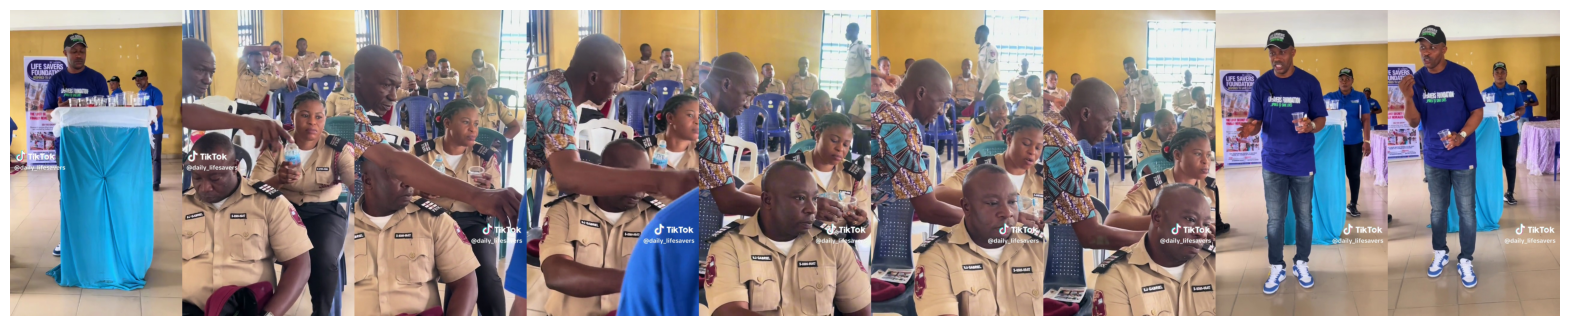

In [21]:
the_vid_id = video_analysis_df.item_id.sample().values[0]
print(tabulate(video_analysis_df[video_analysis_df.item_id==the_vid_id].T, headers="keys", tablefmt="pipe"))
list_of_images = list(all_frames_df[all_frames_df["item_id"]==the_vid_id].sort_values("frame")["image"].values)
if True or all([type(h)=="str" for h in list_of_images]):
    display_images_in_row(list_of_images)
else:
    print("**** ERROR finding key frames")
Video(join(video_dir,f"{the_vid_id}.mp4"), height=300)